# Демо-экзамен по курсу "Прикладной анализ данных". Вариант 2

Выполнил: Маркович Лев Иванович, С22-712

НИЯУ МИФИ

Вставьте ниже скриншот с результатом вашего решения в Leaderboard на Kaggle: https://www.kaggle.com/competitions/lamoda-images-classification/data

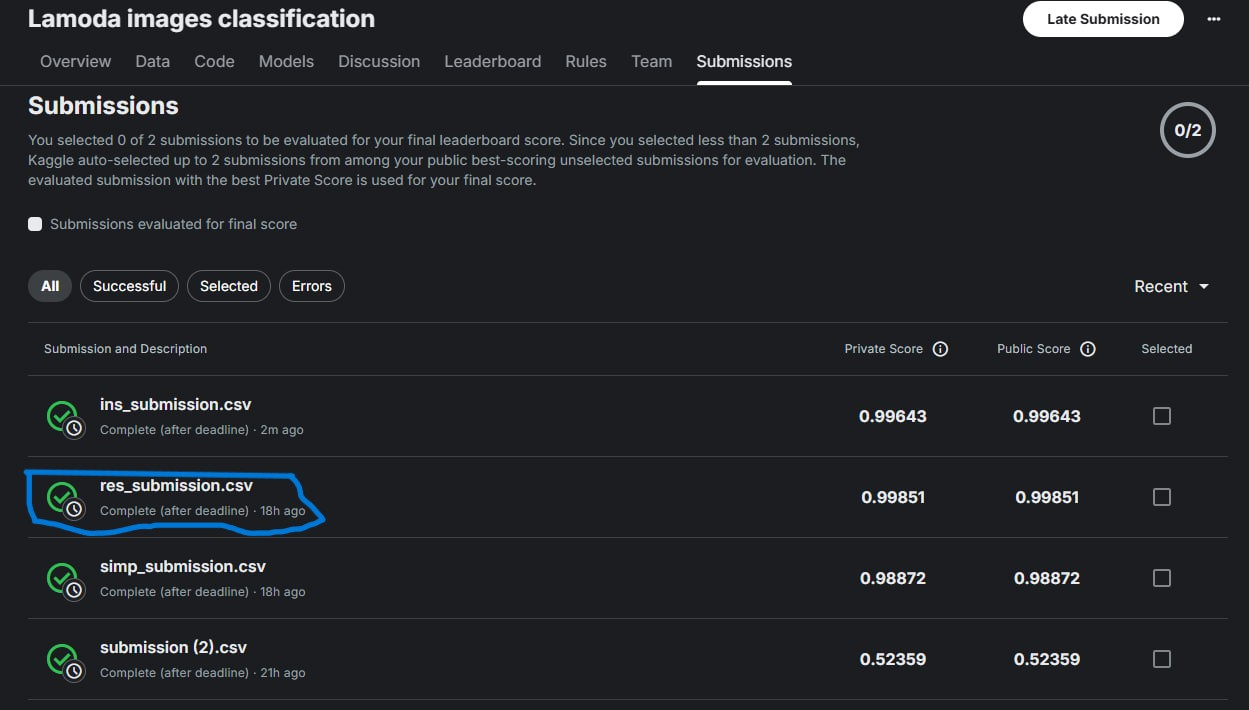

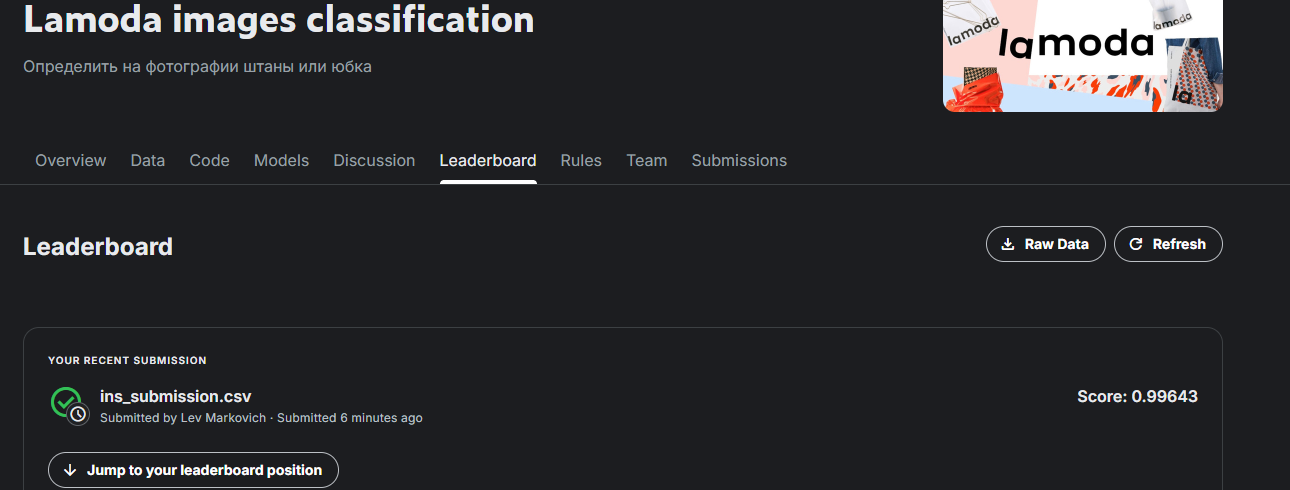

## 1. Описание задачи и данные

В рамках данного задания вам предстоит разработать алгоритм, который автоматически классифицирует изображения предметов одежды на две категории:

- bryuki (брюки),
- bluzy (блузки).

Каждое изображение содержит один предмет одежды на однотонном фоне. Цель — по изображению предсказать, к какому классу принадлежит предмет.

Ссылка на соревнование и на данные: https://www.kaggle.com/competitions/lamoda-images-classification/data

In [2]:
# Import libraries
# TODO

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Пропишите дополнительные библиотеки, которые потребуются для решения
import torch
import numpy as np
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models

from matplotlib import colors, pyplot as plt
import torchvision.transforms as tfs

In [3]:
# установим библиотеку для работы с датасетами на kaggle
!pip install opendatasets --quiet

Небольшая инструкция как напрямую скачать данные с kaggle в Colab ноутбук: https://www.geeksforgeeks.org/python/how-to-import-kaggle-datasets-directly-into-google-colab/

In [4]:
import opendatasets as od
import pandas as pd

url = 'https://www.kaggle.com/competitions/lamoda-images-classification/'
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  levmarkovich


Your Kaggle Key:

  ········


100%|██████████| 265M/265M [00:00<00:00, 1.14GB/s]



Extracting archive ./lamoda-images-classification/lamoda-images-classification.zip to ./lamoda-images-classification


## 1. Провести предварительное исследование данных

- сколько у вас есть изображений? Все ли они одного разрешения? Какой баланс классов в данных?
- какие есть особенности датасета?
- если необходимо произвести очистку и предварительную обработку данных.

In [5]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/working/lamoda-images-classification/images/train')
TEST_DIR = Path('/kaggle/working/lamoda-images-classification/images/test')

train_files=sorted(list(TRAIN_DIR.rglob("*.jpg")))
test_files=sorted(list(TEST_DIR.rglob("*.jpg")))

In [6]:
train_files[0], test_files[0]

(PosixPath('/kaggle/working/lamoda-images-classification/images/train/0001_bluzy.jpg'),
 PosixPath('/kaggle/working/lamoda-images-classification/images/test/0001.jpg'))

In [7]:
len(train_files), len(test_files)

(13476, 3369)

In [8]:
#В тестовых файлах помимо картинки идет еще название -> вытащим его отдельно
train_labels = [path.stem.split("_")[-1] for path in train_files]
train_labels

['bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',
 'bluzy',


In [9]:
print(f'Число изображений для обучения и валидации: {len(train_files)}')
print(f'Число изображений для финальной проверки работы модели: {len(test_files)}')

train_sizes = [Image.open(file).size for file in train_files]
test_sizes = [Image.open(file).size for file in test_files]

unique_train_sizes = set(train_sizes)
unique_test_sizes = set(test_sizes)

print("Уникальные размеры train:", unique_train_sizes)
print("Уникальные размеры test:", unique_test_sizes)

Число изображений для обучения и валидации: 13476
Число изображений для финальной проверки работы модели: 3369
Уникальные размеры train: {(46, 66), (600, 866)}
Уникальные размеры test: {(46, 66), (600, 866)}


In [10]:
counts = pd.Series(train_labels).value_counts()
counts

bluzy     7074
bryuki    6402
Name: count, dtype: int64

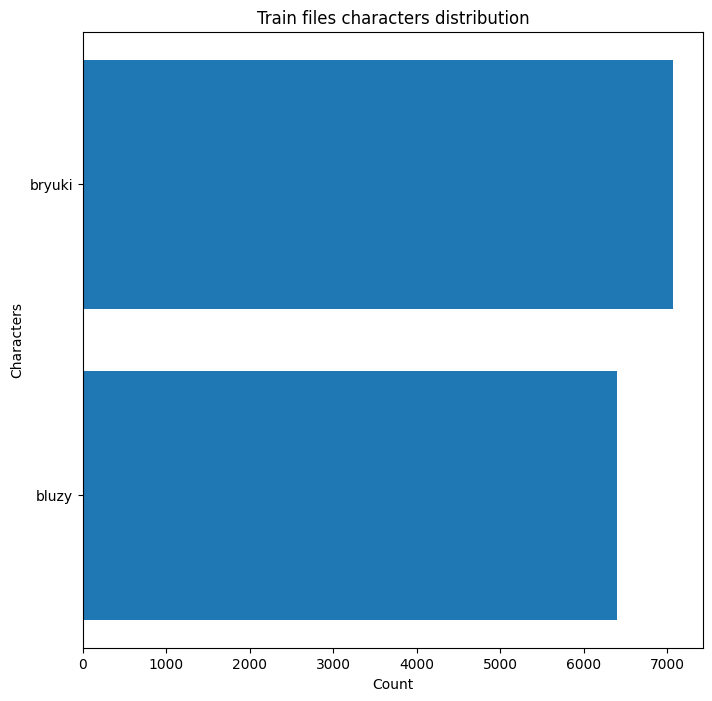

In [11]:
#В целом balanced
plt.figure(figsize=(8,8))
plt.barh(counts.keys(), counts.sort_values(ascending=True))
plt.title('Train files characters distribution')
plt.xlabel('Count')
plt.ylabel('Characters')
plt.show()

Особенности: 2 класса, неплохо сбалансированы, но есть 2 уникальных разрешения -> необходимо привести к одному.

In [12]:
def is_image_valid(path):
    try:
        img = Image.open(path)  # не загружает, но проверяет корректность
        return True
    except:
        return False

valid_train_files = [p for p in train_files if is_image_valid(p)]
print(f"Удалено {len(train_files) - len(valid_train_files)} поврежденных изображений")

Удалено 0 поврежденных изображений


Все файлы открываются

## 2. Подготовить данные для обучения

- Создать тренировочную и тестовую подвыборки для обучения и тестирования работы моделей
- Создать класс на фреймворке `PyTorch` для создания датасета
- Создать `loader` для передачи данных в модель нейронной сети

In [13]:
class MyDataset(Dataset):
    # def __init__ - конструктор класс
    def __init__(self, files, mode, label_encoder=None, labels=None):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        self.labels = labels
        # режим работы
        self.mode = mode

        if self.mode not in ['train', 'val', 'test']:
            raise ValueError(f"Invalid mode {self.mode}. Use 'train', 'val' or 'test'")

        # Усиленная аугментация для тренировки
        self.train_transform = tfs.Compose([
            transforms.Lambda(lambda img: img.convert("RGB")),
            tfs.Resize(299),
            tfs.RandomCrop(299),
            tfs.RandomAffine(degrees=15, shear=10, scale=(0.8, 1.2)),
            tfs.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            tfs.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 0.5)),
            tfs.RandomPerspective(distortion_scale=0.2, p=0.5),
            tfs.RandomHorizontalFlip(),
            tfs.ToTensor(),
            tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            tfs.RandomErasing(p=0.5, scale=(0.02, 0.1))
        ])
        # Для валидации только изменяем саму картинку
        self.val_transform = tfs.Compose([
            transforms.Lambda(lambda img: img.convert("RGB")),
            tfs.Resize(299),
            tfs.CenterCrop(299),
            tfs.ToTensor(),
            tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.len_ = len(self.files)

        #Вытаскиваем лейблы
        if label_encoder is None and mode != 'test':
            self.label_encoder = LabelEncoder()
            self.all_labels = [path.stem.split("_")[-1] for path in files]
            self.label_encoder.fit(self.all_labels)
        else:
            self.label_encoder = label_encoder

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_
    #Для открытия изображений
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        file = self.files[index]
        image = self.load_sample(file)

        if self.mode == 'train':
          image = self.train_transform(image)
        else:
          image = self.val_transform(image)
        #Для теста вообще не изменяем картинки
        if self.mode == 'test':
            return image

        label = self.label_encoder.transform([self.labels[index]])[0]
        return image, label

In [14]:
all_labels = [path.stem.split("_")[-1] for path in train_files]

# Создаем и обучаем encoder
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

LabelEncoder()

In [15]:
from sklearn.model_selection import train_test_split
#Разделим на подвыборки и стратифицируем по лейблам, важно сохранить соответствие лейблов картинкам
files_with_labels = [(path, path.stem.split("_")[-1]) for path in train_files]
train_files_split, val_files_split = train_test_split(
    files_with_labels,
    test_size=0.25,
    stratify=[label for (_, label) in files_with_labels]
)

In [16]:
# Разделяем обратно на файлы и метки
train_files = [path for (path, _) in train_files_split]
val_files = [path for (path, _) in val_files_split]
train_labels = [label for (_, label) in train_files_split]
val_labels = [label for (_, label) in val_files_split]

In [17]:
len(train_files), len(val_files)

(10107, 3369)

In [18]:
train_files[49].name, train_labels[49]

('0631_bluzy.jpg', 'bluzy')

In [19]:
train_dataset = MyDataset(train_files, mode='train', label_encoder=label_encoder, labels=train_labels)
test_dataset = MyDataset(test_files, mode='test')
val_dataset = MyDataset(val_files, mode='val', label_encoder=label_encoder, labels=val_labels)

In [20]:
for i in range(5):
    print(f"Файл: {val_dataset.files[i].name}, Метка: {val_dataset[i][1]}")

Файл: 1509_bluzy.jpg, Метка: 0
Файл: 5779_bluzy.jpg, Метка: 0
Файл: 5706_bluzy.jpg, Метка: 0
Файл: 6254_bluzy.jpg, Метка: 0
Файл: 14186_bryuki.jpg, Метка: 1


In [21]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

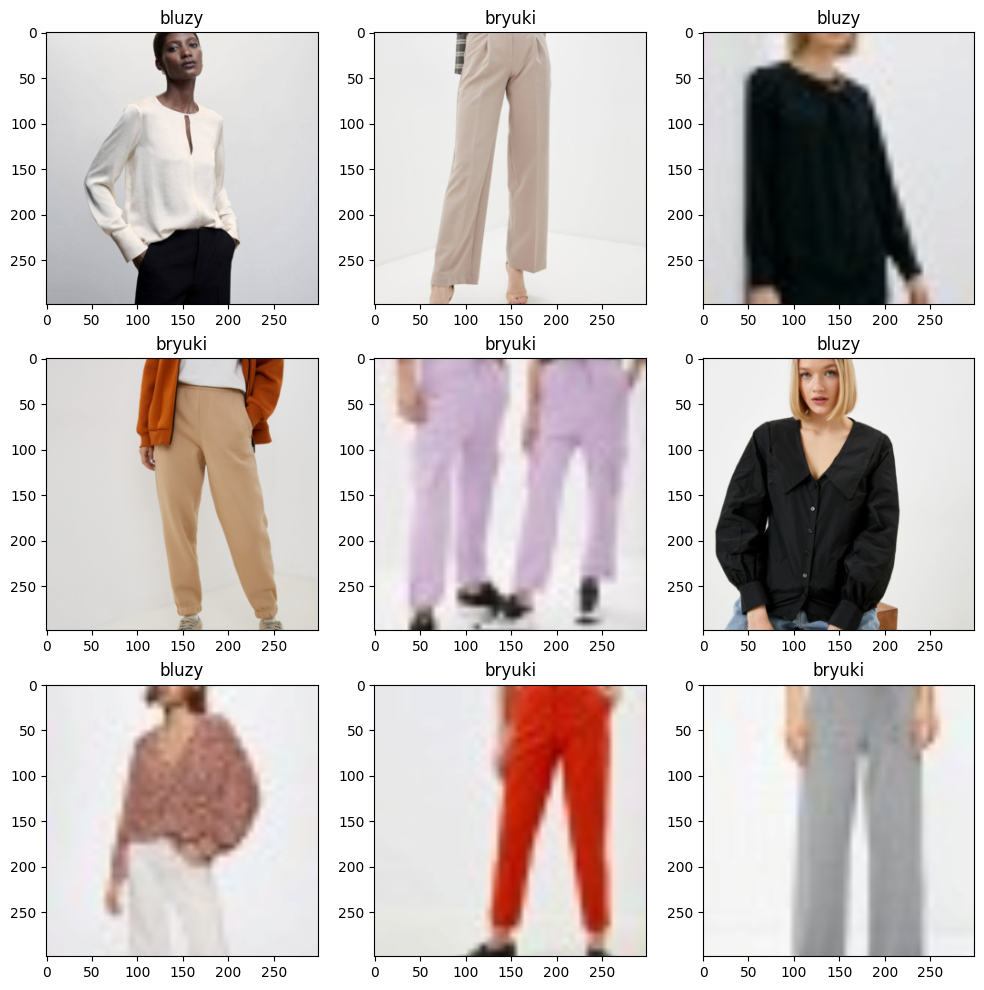

In [37]:
#Посмотрим что получилось

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12))

for fig_x in ax.flatten():
    idx = np.random.randint(0, len(val_dataset))
    #Возьмем рандомные изображения из val
    im_val, label = val_dataset[idx]
    #Возьмем их лейблы, переформатируем
    img_label = val_dataset.label_encoder.classes_[label]
    #Отрисуем с помощью вспомогательной функции
    imshow(im_val, title=img_label, plt_ax=fig_x)

## 3. Реализация модели

- создать класс для модели
- создать функцию для обучения модели
- создать функцию для валидации модели

In [24]:
#Для начала сами напишем простую модель, здесь только Conv слои, ReLU и макс пулинги, на вход подается RGB изображение размерности (3, H, W)
#На выходе используется полносвязный слой для классификации на наше количество классов(2)
class RSNAModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(3456, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [25]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


In [26]:
def train_one_epoch(model, train_dataloader, optimizer, criterion):
    '''
    Эта функция проходит по всем данным в `train_dataloader`, выполняет шаг моделью (forward),
    вычисляет лосс, выполняет обратное распространение с помощью заданного
    оптимизатора и обновляет веса модели.
    В конце эпохи возвращаются средний лосс и
    точность на обучающем наборе данных.
    '''

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        outputs = outputs.view(-1)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).long()
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss/processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def valid_one_epoch(model, valid_dataloader, criterion):
    '''
    Эта функция проходит по всем данным в `val_loader`, выполняет прямое
    распространение, вычисляет лосс и точность модели. В конце эпохи
    возвращаются средний лосс и точность на валидационном наборе данных.
    '''
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in valid_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        #Не вычисляем градиенты на val
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            outputs = outputs.view(-1)
            loss = criterion(outputs, labels.float())
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()

        running_loss += loss.item() * inputs.size(0)
        #Считаем корректно предсказанные
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss/processed_size
    val_acc = running_corrects.cpu().numpy()/processed_size
    return val_loss, val_acc

## 4. Обучение модели
*   Определить необходимые параметры для обучения модели (learning rate, optimizer, loss function, etc)
*   Реализовать процесс обучения модели
*   Оценить эффективность работы модели



In [27]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [28]:
#Сделаем функции для тренировки и обучения модели на заданном количестве эпох
def train(train_files, val_files, model, epochs, batch_size):
  '''
  Эта функция создает загрузчики данных для обучающего и валидационного наборов,
  а затем выполняет обучение модели в течение заданного количества эпох.
  В конце каждой эпохи выводятся значения потерь и точности для обучающего и
  валидационного наборов. История обучения сохраняется и возвращается.
  '''
  #shuffle используется только при тренировке
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  history = []
  log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

  # Инициализация весов
  model.apply(init_weights)
  opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
  #Шедулер для лучшего обучения
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=3)
  criterion = nn.BCEWithLogitsLoss()

  best_acc = 0.0
  early_stop_patience = 5
  no_improve = 0

  #Используем AdamW который чуть умнее обычного Adam и бинарную кросс энтропию для задачи бинарной классификации
  with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            model.train()
            train_loss, train_acc = train_one_epoch(model, train_loader, opt, criterion)

            model.eval()
            val_loss, val_acc = valid_one_epoch(model, val_loader, criterion)

            scheduler.step(val_loss)

            # Ранняя остановка
            if val_acc > best_acc:
                best_acc = val_acc
                no_improve = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                no_improve += 1
                if no_improve >= early_stop_patience:
                    print(f"\nEarly stopping at epoch {epoch+1}")
                    break

            history.append((train_loss, train_acc, val_loss, val_acc))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                         v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
  return history

In [29]:
def predict(model, test_loader):
  '''
  Эта функция принимает модель и загрузчик тестовых данных, применяет модель к
  изображениям и возвращает вероятности предсказанных классов.
  '''

  with torch.no_grad():
    logits = []

    model.eval()
    for inputs in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        outputs = outputs.squeeze(1)
        logits.append(outputs.cpu())
  #Возвращаем массив предсказанных классов
  all_output = torch.cat(logits, dim=0)
  probs = torch.sigmoid(all_output)
  preds = (probs > 0.5).long()
  return preds

In [38]:
simple_cnn = RSNAModel().to(DEVICE)
simple_cnn

RSNAModel(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=3456, out_features=1, bias=True)
)

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=20, batch_size=64)

epoch:   5%|▌         | 1/20 [02:23<45:30, 143.69s/it]


Epoch 001 train_loss: 0.4014     val_loss 0.1474 train_acc 0.8121 val_acc 0.9463


epoch:  10%|█         | 2/20 [04:46<42:58, 143.27s/it]


Epoch 002 train_loss: 0.2274     val_loss 0.1062 train_acc 0.9099 val_acc 0.9570


epoch:  15%|█▌        | 3/20 [07:09<40:29, 142.93s/it]


Epoch 003 train_loss: 0.1890     val_loss 0.0845 train_acc 0.9254 val_acc 0.9733


epoch:  20%|██        | 4/20 [09:29<37:50, 141.88s/it]


Epoch 004 train_loss: 0.1736     val_loss 0.0912 train_acc 0.9360 val_acc 0.9623


epoch:  25%|██▌       | 5/20 [11:55<35:48, 143.25s/it]


Epoch 005 train_loss: 0.1605     val_loss 0.0715 train_acc 0.9368 val_acc 0.9733


epoch:  30%|███       | 6/20 [14:19<33:31, 143.67s/it]


Epoch 006 train_loss: 0.1489     val_loss 0.0645 train_acc 0.9420 val_acc 0.9834


epoch:  35%|███▌      | 7/20 [16:40<30:55, 142.74s/it]


Epoch 007 train_loss: 0.1350     val_loss 0.0540 train_acc 0.9497 val_acc 0.9855


epoch:  40%|████      | 8/20 [19:04<28:38, 143.18s/it]


Epoch 008 train_loss: 0.1326     val_loss 0.0560 train_acc 0.9506 val_acc 0.9849


epoch:  45%|████▌     | 9/20 [21:27<26:15, 143.21s/it]


Epoch 009 train_loss: 0.1274     val_loss 0.0474 train_acc 0.9537 val_acc 0.9878


epoch:  50%|█████     | 10/20 [23:52<23:57, 143.75s/it]


Epoch 010 train_loss: 0.1251     val_loss 0.0690 train_acc 0.9520 val_acc 0.9733


epoch:  55%|█████▌    | 11/20 [26:14<21:28, 143.13s/it]


Epoch 011 train_loss: 0.1195     val_loss 0.0509 train_acc 0.9555 val_acc 0.9872


epoch:  60%|██████    | 12/20 [28:35<19:00, 142.58s/it]


Epoch 012 train_loss: 0.1068     val_loss 0.0579 train_acc 0.9614 val_acc 0.9810


epoch:  65%|██████▌   | 13/20 [30:56<16:34, 142.11s/it]


Epoch 013 train_loss: 0.1030     val_loss 0.0436 train_acc 0.9639 val_acc 0.9890


epoch:  70%|███████   | 14/20 [33:19<14:13, 142.17s/it]


Epoch 014 train_loss: 0.1026     val_loss 0.0660 train_acc 0.9628 val_acc 0.9742


epoch:  75%|███████▌  | 15/20 [35:42<11:52, 142.52s/it]


Epoch 015 train_loss: 0.1017     val_loss 0.0425 train_acc 0.9617 val_acc 0.9878


epoch:  80%|████████  | 16/20 [38:07<09:32, 143.11s/it]


Epoch 016 train_loss: 0.0888     val_loss 0.0455 train_acc 0.9678 val_acc 0.9884


epoch:  85%|████████▌ | 17/20 [40:28<07:07, 142.60s/it]


Epoch 017 train_loss: 0.0979     val_loss 0.0481 train_acc 0.9648 val_acc 0.9837


In [40]:
loss, acc, val_loss, val_acc = zip(*history)

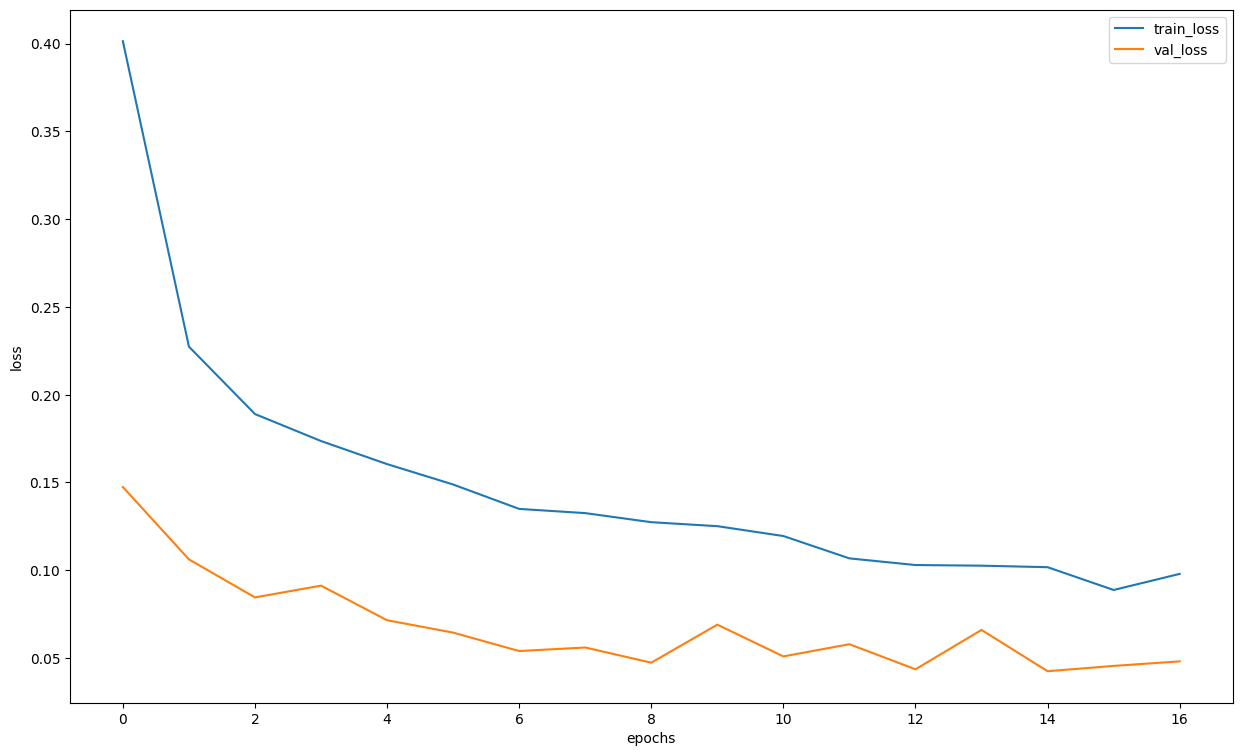

In [41]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [42]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)
probs = predict(simple_cnn, test_loader)

In [43]:
probs

tensor([0, 0, 0,  ..., 1, 1, 1])

In [44]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [45]:
preds = label_encoder.inverse_transform(probs)
test_filenames = [path.name for path in test_dataset.files]

In [46]:
preds

array(['bluzy', 'bluzy', 'bluzy', ..., 'bryuki', 'bryuki', 'bryuki'],
      dtype='<U6')

In [47]:
test_filenames

['0001.jpg',
 '0002.jpg',
 '0003.jpg',
 '0004.jpg',
 '0005.jpg',
 '0006.jpg',
 '0007.jpg',
 '0008.jpg',
 '0009.jpg',
 '0010.jpg',
 '0011.jpg',
 '0012.jpg',
 '0013.jpg',
 '0014.jpg',
 '0015.jpg',
 '0016.jpg',
 '0017.jpg',
 '0018.jpg',
 '0019.jpg',
 '0020.jpg',
 '0021.jpg',
 '0022.jpg',
 '0023.jpg',
 '0024.jpg',
 '0025.jpg',
 '0026.jpg',
 '0027.jpg',
 '0028.jpg',
 '0029.jpg',
 '0030.jpg',
 '0031.jpg',
 '0032.jpg',
 '0033.jpg',
 '0034.jpg',
 '0035.jpg',
 '0036.jpg',
 '0037.jpg',
 '0038.jpg',
 '0039.jpg',
 '0040.jpg',
 '0041.jpg',
 '0042.jpg',
 '0043.jpg',
 '0044.jpg',
 '0045.jpg',
 '0046.jpg',
 '0047.jpg',
 '0048.jpg',
 '0049.jpg',
 '0050.jpg',
 '0051.jpg',
 '0052.jpg',
 '0053.jpg',
 '0054.jpg',
 '0055.jpg',
 '0056.jpg',
 '0057.jpg',
 '0058.jpg',
 '0059.jpg',
 '0060.jpg',
 '0061.jpg',
 '0062.jpg',
 '0063.jpg',
 '0064.jpg',
 '0065.jpg',
 '0066.jpg',
 '0067.jpg',
 '0068.jpg',
 '0069.jpg',
 '0070.jpg',
 '0071.jpg',
 '0072.jpg',
 '0073.jpg',
 '0074.jpg',
 '0075.jpg',
 '0076.jpg',
 '0077.jpg',

In [48]:
pd.Series(preds).value_counts()

bluzy     1788
bryuki    1581
Name: count, dtype: int64

In [49]:
test = pd.DataFrame({
    "index": test_filenames,
    "label": preds
})

In [51]:
test.to_csv('simp_submission.csv', index = False)

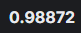

# Отлично предсказывает даже такая простая модель

## 5. Экспериментальная часть

- протестировать не менее 3х разных моделей для решения задачи
- сравнить их эффективность (по метрикам и потерям)
- сделать выводы

In [52]:
#Попробуем реснет
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


In [53]:
#Модель достаточно умнее предыдущей, добавлены батчнормы, даунсемплы, Adaptive average pooling
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [54]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1)
)

In [55]:
res_model = model.to(DEVICE)

In [56]:
history = train(train_dataset, val_dataset, model=res_model, epochs=20, batch_size=64)

epoch:   5%|▌         | 1/20 [02:49<53:30, 169.00s/it]


Epoch 001 train_loss: 0.6707     val_loss 0.7081 train_acc 0.6022 val_acc 0.5515


epoch:  10%|█         | 2/20 [05:36<50:27, 168.21s/it]


Epoch 002 train_loss: 0.3564     val_loss 0.1217 train_acc 0.8430 val_acc 0.9549


epoch:  15%|█▌        | 3/20 [08:24<47:39, 168.22s/it]


Epoch 003 train_loss: 0.1399     val_loss 0.0418 train_acc 0.9455 val_acc 0.9908


epoch:  20%|██        | 4/20 [11:12<44:44, 167.79s/it]


Epoch 004 train_loss: 0.0974     val_loss 0.0512 train_acc 0.9619 val_acc 0.9878


epoch:  25%|██▌       | 5/20 [14:01<42:06, 168.46s/it]


Epoch 005 train_loss: 0.0796     val_loss 0.0199 train_acc 0.9695 val_acc 0.9953


epoch:  30%|███       | 6/20 [16:52<39:27, 169.13s/it]


Epoch 006 train_loss: 0.0716     val_loss 0.0389 train_acc 0.9748 val_acc 0.9887


epoch:  35%|███▌      | 7/20 [19:41<36:39, 169.22s/it]


Epoch 007 train_loss: 0.0598     val_loss 0.0238 train_acc 0.9801 val_acc 0.9920


epoch:  40%|████      | 8/20 [22:30<33:49, 169.12s/it]


Epoch 008 train_loss: 0.0577     val_loss 0.0362 train_acc 0.9804 val_acc 0.9875


epoch:  45%|████▌     | 9/20 [25:21<31:05, 169.58s/it]


Epoch 009 train_loss: 0.0461     val_loss 0.0178 train_acc 0.9841 val_acc 0.9955


epoch:  50%|█████     | 10/20 [28:11<28:17, 169.78s/it]


Epoch 010 train_loss: 0.0447     val_loss 0.0220 train_acc 0.9845 val_acc 0.9941


epoch:  55%|█████▌    | 11/20 [31:01<25:28, 169.87s/it]


Epoch 011 train_loss: 0.0441     val_loss 0.1053 train_acc 0.9850 val_acc 0.9671


epoch:  60%|██████    | 12/20 [33:52<22:42, 170.26s/it]


Epoch 012 train_loss: 0.0395     val_loss 0.0315 train_acc 0.9860 val_acc 0.9887


epoch:  65%|██████▌   | 13/20 [36:43<19:52, 170.35s/it]


Epoch 013 train_loss: 0.0334     val_loss 0.0219 train_acc 0.9891 val_acc 0.9935


epoch:  70%|███████   | 14/20 [39:34<17:03, 170.58s/it]


Epoch 014 train_loss: 0.0327     val_loss 0.0149 train_acc 0.9895 val_acc 0.9964


epoch:  75%|███████▌  | 15/20 [42:24<14:12, 170.58s/it]


Epoch 015 train_loss: 0.0278     val_loss 0.0162 train_acc 0.9914 val_acc 0.9955


epoch:  80%|████████  | 16/20 [45:14<11:21, 170.45s/it]


Epoch 016 train_loss: 0.0281     val_loss 0.0145 train_acc 0.9905 val_acc 0.9955


epoch:  85%|████████▌ | 17/20 [48:05<08:31, 170.42s/it]


Epoch 017 train_loss: 0.0209     val_loss 0.0155 train_acc 0.9937 val_acc 0.9958


epoch:  90%|█████████ | 18/20 [50:54<05:40, 170.19s/it]


Epoch 018 train_loss: 0.0232     val_loss 0.0153 train_acc 0.9923 val_acc 0.9964


epoch:  90%|█████████ | 18/20 [53:45<05:58, 179.20s/it]


Early stopping at epoch 19


In [57]:
loss, acc, val_loss, val_acc = zip(*history)

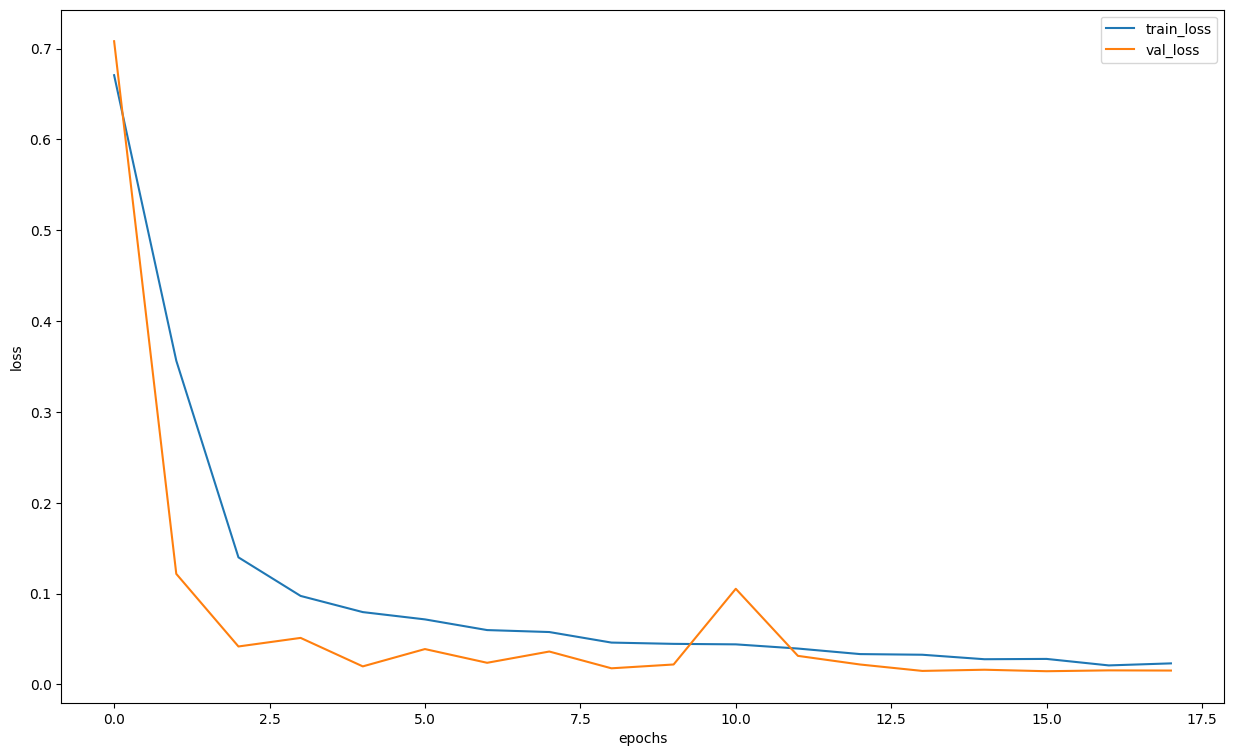

In [58]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [59]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)
probs_res = predict(res_model, test_loader)

In [60]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [61]:
preds_res = label_encoder.inverse_transform(probs_res)
test_filenames = [path.name for path in test_dataset.files]

In [62]:
preds_res

array(['bluzy', 'bluzy', 'bluzy', ..., 'bryuki', 'bryuki', 'bryuki'],
      dtype='<U6')

In [63]:
pd.Series(preds_res).value_counts()

bluzy     1767
bryuki    1602
Name: count, dtype: int64

In [64]:
test_res = pd.DataFrame({
    "index": test_filenames,
    "label": preds_res
})

In [65]:
test_res.to_csv('res_submission.csv', index = False)

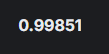

# Score еще возрос, что ожидаемо от более сложной модели

In [22]:
from torchvision.models import inception_v3, Inception_V3_Weights
#Попробуем еще архитектуру inception 
weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights, aux_logits=True)
model.aux_logits = False
model

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:06<00:00, 18.0MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [23]:
model.fc = nn.Linear(model.fc.in_features, 1)

In [30]:
inception = model.to(DEVICE)

In [31]:
history = train(train_dataset, val_dataset, model=inception, epochs=20, batch_size=64)

epoch:   5%|▌         | 1/20 [05:07<1:37:19, 307.36s/it]


Epoch 001 train_loss: 0.7058     val_loss 0.6786 train_acc 0.5229 val_acc 0.5248


epoch:  10%|█         | 2/20 [10:18<1:32:48, 309.36s/it]


Epoch 002 train_loss: 0.6865     val_loss 0.6755 train_acc 0.5400 val_acc 0.5331


epoch:  15%|█▌        | 3/20 [15:28<1:27:47, 309.87s/it]


Epoch 003 train_loss: 0.6654     val_loss 0.6533 train_acc 0.5720 val_acc 0.5883


epoch:  20%|██        | 4/20 [20:40<1:22:48, 310.51s/it]


Epoch 004 train_loss: 0.4689     val_loss 0.1653 train_acc 0.7788 val_acc 0.9673


epoch:  25%|██▌       | 5/20 [25:53<1:17:53, 311.58s/it]


Epoch 005 train_loss: 0.2365     val_loss 0.0574 train_acc 0.9135 val_acc 0.9869


epoch:  30%|███       | 6/20 [31:07<1:12:53, 312.39s/it]


Epoch 006 train_loss: 0.1375     val_loss 0.0515 train_acc 0.9503 val_acc 0.9858


epoch:  35%|███▌      | 7/20 [36:19<1:07:41, 312.40s/it]


Epoch 007 train_loss: 0.1035     val_loss 0.0311 train_acc 0.9635 val_acc 0.9887


epoch:  40%|████      | 8/20 [41:30<1:02:22, 311.90s/it]


Epoch 008 train_loss: 0.0865     val_loss 0.0352 train_acc 0.9691 val_acc 0.9893


epoch:  45%|████▌     | 9/20 [46:44<57:16, 312.38s/it]  


Epoch 009 train_loss: 0.0696     val_loss 0.0206 train_acc 0.9766 val_acc 0.9944


epoch:  50%|█████     | 10/20 [51:56<52:02, 312.21s/it]


Epoch 010 train_loss: 0.0675     val_loss 0.0261 train_acc 0.9763 val_acc 0.9914


epoch:  55%|█████▌    | 11/20 [57:09<46:52, 312.45s/it]


Epoch 011 train_loss: 0.0601     val_loss 0.0182 train_acc 0.9801 val_acc 0.9953


epoch:  60%|██████    | 12/20 [1:02:22<41:41, 312.63s/it]


Epoch 012 train_loss: 0.0502     val_loss 0.0145 train_acc 0.9822 val_acc 0.9973


epoch:  65%|██████▌   | 13/20 [1:07:35<36:30, 312.95s/it]


Epoch 013 train_loss: 0.0422     val_loss 0.0208 train_acc 0.9860 val_acc 0.9938


epoch:  70%|███████   | 14/20 [1:12:46<31:14, 312.38s/it]


Epoch 014 train_loss: 0.0413     val_loss 0.0150 train_acc 0.9858 val_acc 0.9973


epoch:  75%|███████▌  | 15/20 [1:17:57<25:59, 311.95s/it]


Epoch 015 train_loss: 0.0424     val_loss 0.0159 train_acc 0.9850 val_acc 0.9953


epoch:  80%|████████  | 16/20 [1:23:08<20:46, 311.63s/it]


Epoch 016 train_loss: 0.0441     val_loss 0.0180 train_acc 0.9854 val_acc 0.9950


epoch:  80%|████████  | 16/20 [1:28:19<22:04, 331.23s/it]


Early stopping at epoch 17


In [32]:
loss, acc, val_loss, val_acc = zip(*history)

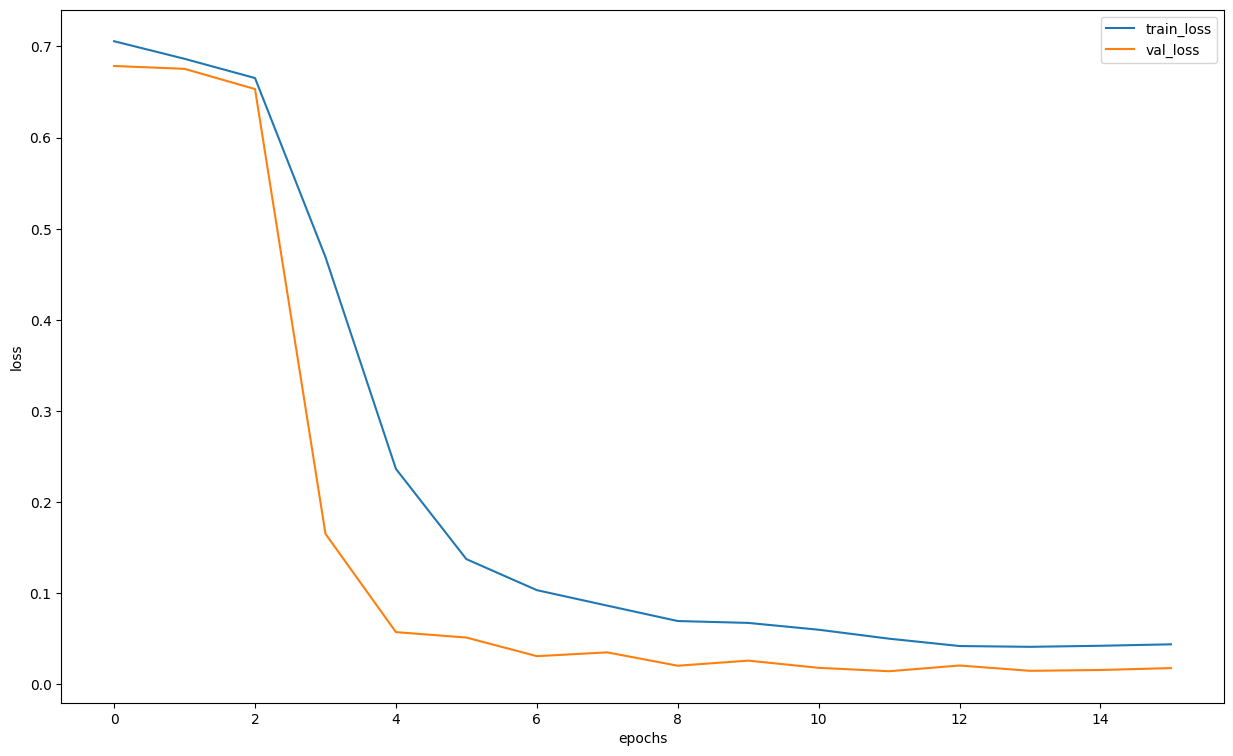

In [33]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [34]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)
probs_ins = predict(inception, test_loader)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [35]:
preds_ins = label_encoder.inverse_transform(probs_ins)
test_filenames = [path.name for path in test_dataset.files]

In [36]:
pd.Series(preds_ins).value_counts()

bluzy     1776
bryuki    1593
Name: count, dtype: int64

In [37]:
test_ins = pd.DataFrame({
    "index": test_filenames,
    "label": preds_ins
})

In [38]:
test_ins.to_csv('ins_submission.csv', index = False)

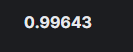

Немного хуже, но разница в 2 тысячных невелика

# Итого - 3 разные модели, в целом все справились неплохо, но resnet18 все же справилась лучше по accuracy, но это не значит, что она лучшая во всём, поэтому можно сказать что все модели предсказывают отлично.